In [1]:
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.callbacks import *

Using TensorFlow backend.


In [2]:
### READ DATA ###

df = pd.read_csv('Punta_Salute_2009.csv', sep=';')
df = df.dropna()

print(df.shape)
df.head()

(8760, 3)


,Data,Ora solare,Livello P.Salute Canal Grande (cm)
0,01-gen-09,01:00,34.0
1,01-gen-09,02:00,37.0
2,01-gen-09,03:00,36.0
3,01-gen-09,04:00,29.0
4,01-gen-09,05:00,20.0


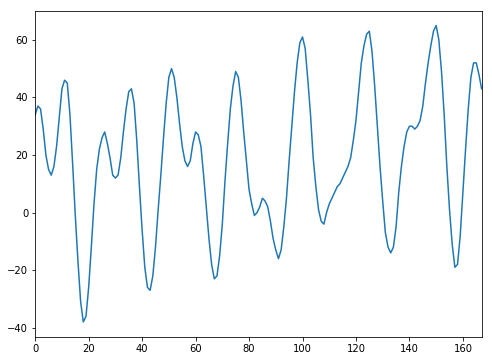

In [3]:
### PLOT WEEKLY TREND ###

df[:7*24]['Livello P.Salute Canal Grande (cm)'].plot(y='Livello P.Salute Canal Grande (cm)', x='Ora solare', figsize=(8,6))

In [4]:
### DEFINE T2V LAYER ###

class T2V(Layer):

    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.W = self.add_weight(name='W', 
                              shape=(self.output_dim, self.output_dim),
                              initializer='uniform',
                              trainable=True)
        
        self.B = self.add_weight(name='B', 
                              shape=(input_shape[1], self.output_dim),
                              initializer='uniform',
                              trainable=True)
        
        self.w = self.add_weight(name='w', 
                              shape=(1, 1),
                              initializer='uniform',
                              trainable=True)
        
        self.b = self.add_weight(name='b', 
                              shape=(input_shape[1], 1),
                              initializer='uniform',
                              trainable=True)
        
        super(T2V, self).build(input_shape) 

    def call(self, x):
        original = self.w * x + self.b
        x = K.repeat_elements(x, self.output_dim, -1)
        sin_trans = K.sin(K.dot(x, self.W) + self.B)
        return K.concatenate([sin_trans,original], -1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_dim+1)

In [5]:
### CREATE GENERATOR FOR LSTM AND T2V ###

sequence_length = 24

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [6]:
### DEFINE MODEL STRUCTURES ###

def T2V_NN(dim, t2v_dim):
    inp = Input(shape=(dim,1))
    x = T2V(t2v_dim)(inp)
    x = LSTM(32)(x)
    x = Dense(1)(x)
    m = Model(inp, x)
    return m

def NN(dim):
    inp = Input(shape=(dim,1))
    x = LSTM(32)(inp)
    x = Dense(1)(x)
    m = Model(inp, x)
    return m

In [7]:
### PREPARE DATA TO FEED MODELS ###

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['Livello P.Salute Canal Grande (cm)']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['Livello P.Salute Canal Grande (cm)']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

In [8]:
### TRAIN TEST SPLIT ###

train_dim = int(0.7*len(df))
X_train, X_test = X[:train_dim], X[train_dim:]
y_train, y_test = Y[:train_dim], Y[train_dim:]

In [9]:
### FIT T2V + LSTM ###

nnT2V = T2V_NN(sequence_length, 128)
nnT2V.compile(loss='mse', optimizer='adam')

nnT2V.fit(X_train, y_train, epochs=100, batch_size=256, verbose=2, shuffle=True, validation_split=0.2)

Train on 4905 samples, validate on 1227 samples
Epoch 1/100
 - 2s - loss: 1805.4887 - val_loss: 1270.0642
Epoch 2/100
 - 1s - loss: 1730.7855 - val_loss: 1148.1836
Epoch 3/100
 - 1s - loss: 1516.0782 - val_loss: 966.8481
Epoch 4/100
 - 1s - loss: 1343.3823 - val_loss: 872.4604
Epoch 5/100
 - 1s - loss: 1266.9979 - val_loss: 835.2742
Epoch 6/100
 - 1s - loss: 1224.9488 - val_loss: 804.1972
Epoch 7/100
 - 1s - loss: 1186.6775 - val_loss: 778.9832
Epoch 8/100
 - 1s - loss: 1152.8306 - val_loss: 749.9148
Epoch 9/100
 - 1s - loss: 1121.2801 - val_loss: 731.4761
Epoch 10/100
 - 1s - loss: 1088.6156 - val_loss: 700.0452
Epoch 11/100
 - 1s - loss: 1055.3302 - val_loss: 678.3302
Epoch 12/100
 - 1s - loss: 1023.1545 - val_loss: 648.9630
Epoch 13/100
 - 1s - loss: 990.2469 - val_loss: 629.9951
Epoch 14/100
 - 1s - loss: 962.0220 - val_loss: 603.4364
Epoch 15/100
 - 1s - loss: 940.9858 - val_loss: 610.8592
Epoch 16/100
 - 1s - loss: 927.9859 - val_loss: 577.2560
Epoch 17/100
 - 1s - loss: 892.2696

In [10]:
pred_t2v = nnT2V.predict(X_test).ravel()
mean_absolute_error(y_test.ravel(), pred_t2v)

9.232769742562292

In [11]:
### FIT SIMPLE LSTM ###

nn = NN(sequence_length)
nn.compile(loss='mse', optimizer='adam')

nn.fit(X_train, y_train, epochs=100, batch_size=256, verbose=2, shuffle=True, validation_split=0.2)

Train on 4905 samples, validate on 1227 samples
Epoch 1/100
 - 1s - loss: 1812.3703 - val_loss: 1274.2898
Epoch 2/100
 - 0s - loss: 1769.5131 - val_loss: 1236.1319
Epoch 3/100
 - 0s - loss: 1726.6838 - val_loss: 1194.9719
Epoch 4/100
 - 0s - loss: 1672.3331 - val_loss: 1136.4726
Epoch 5/100
 - 0s - loss: 1591.5405 - val_loss: 1059.6528
Epoch 6/100
 - 0s - loss: 1500.0675 - val_loss: 997.8372
Epoch 7/100
 - 0s - loss: 1436.6434 - val_loss: 959.7168
Epoch 8/100
 - 0s - loss: 1393.3023 - val_loss: 930.6751
Epoch 9/100
 - 0s - loss: 1358.5480 - val_loss: 904.5518
Epoch 10/100
 - 0s - loss: 1326.4337 - val_loss: 880.0787
Epoch 11/100
 - 0s - loss: 1296.6664 - val_loss: 856.9271
Epoch 12/100
 - 0s - loss: 1268.9663 - val_loss: 834.6487
Epoch 13/100
 - 0s - loss: 1240.3684 - val_loss: 807.8576
Epoch 14/100
 - 0s - loss: 1207.6688 - val_loss: 784.8106
Epoch 15/100
 - 0s - loss: 1180.4483 - val_loss: 763.8001
Epoch 16/100
 - 0s - loss: 1155.1846 - val_loss: 743.7635
Epoch 17/100
 - 0s - loss: 1

In [12]:
pred_nn = nn.predict(X_test).ravel()
mean_absolute_error(y_test.ravel(), pred_nn)

13.124163846747116

# COMPARE RESULTS WITH BOOTSRAPPING

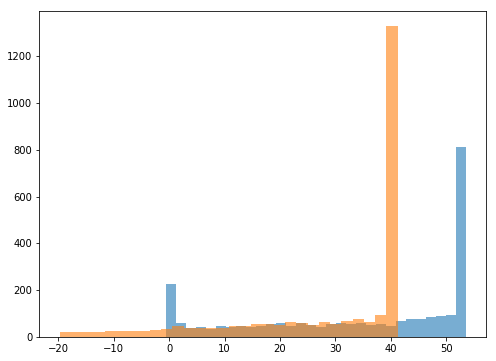

In [13]:
### PLOT PREDICTION DISTRIBUTIONS ###

plt.figure(figsize=(8,6))
plt.hist(pred_t2v, bins=30, alpha = 0.6)
plt.hist(pred_nn, bins=30, alpha = 0.6)

np.set_printoptions(False)

In [14]:
### BOOTSTRAPPED PREDICTION DISTRIBUTIONS ###

sample_t2v_pred = []
for _ in range(1000):
    sample_mean = np.random.choice(pred_t2v, 100).mean()
    sample_t2v_pred.append(sample_mean)

sample_nn_pred = []
for _ in range(1000):
    sample_mean = np.random.choice(pred_nn, 100).mean()
    sample_nn_pred.append(sample_mean)

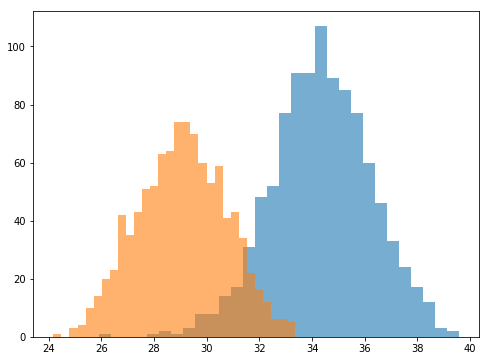

In [15]:
### PLOT BOOTSTRAPPED PREDICTION DISTRIBUTIONS ###

plt.figure(figsize=(8,6))
plt.hist(sample_t2v_pred, bins=30, alpha = 0.6)
plt.hist(sample_nn_pred, bins=30, alpha = 0.6)

np.set_printoptions(False)

In [16]:
np.quantile(sample_nn_pred, 0.9)

31.223380088806152

In [17]:
np.quantile(sample_t2v_pred, 0.1)

31.994068908691407